In [1]:
# use the .py script will be faster
import re 
import numpy as np
import obspy
from obspy import UTCDateTime
from ccfj import CC
from ccfj import GetStationPairs
from concurrent.futures import ThreadPoolExecutor
import os
import time
from geopy.distance import great_circle

In [2]:
Dir = '/mnt/d/Data/USArrayNoise/FJ-Validation/4Hz/SAC' # dir that store the SAC data
dirs = os.listdir(Dir)

In [3]:
# Check if the data exists
def Checkdata(dirname):
    global year
    global day
    global Dir
    filename = os.path.join(Dir,dirname)
    filename = os.path.join(filename,dirname+'-'+year+'-'+day+'-BHZ.SAC')
    if os.path.exists(filename):
        return True
    return False

# Set the rules for reading data
# this will determined by the data files' distribution 
def Readdata(i):
    global year
    global day
    global Dir
    global npts
    global namelist
    global Fs
    global data
    global startend
    dirname = namelist[i]
    filename = os.path.join(Dir,dirname)
    filename = os.path.join(filename,dirname+'-'+year+'-'+day+'-BHZ.SAC')
    st = obspy.read(filename)
    st[0].detrend(type='constant')
    st[0].detrend("spline",order=3,dspline=400)
    if st[0].stats.npts>=npts:
        data[npts*i:npts*(i+1)] = st[0].data[0:npts]
        startend[i*2] = 0
        startend[i*2+1] = npts
    else:
        t0 = UTCDateTime(st[0].stats.starttime)
        idx0 = int((t0.second+t0.minute*60+t0.hour*60*60)*Fs)
        t1 = UTCDateTime(st[0].stats.endtime)
        idx1 = int((t1.second+t1.minute*60+t1.hour*60*60)*Fs)
        data[(npts*i+idx0):(npts*i+idx1)] = st[0].data[0:(idx1-idx0)]
        startend[i*2] = idx0
        startend[i*2+1] = idx1

In [4]:
# Set Params
Fs = 4
npts = 60*60*24*Fs
nf = 1000
fstride = 3
nThreads = 20
fftlen = Fs*60*60
overlaprate = 0.9
nThreads = 20
f = np.arange(0,nf)*Fs/fftlen*fstride
outdir = 'output'
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [5]:
start = time.time()
for y in range(2011,2012):
    for d in range(1,365): 
        year = str(y)
        day = "%03d"%d
        print("year"+year+" day"+day)
        namelist = []
        for dirname in dirs:
            if Checkdata(dirname):
                namelist.append(dirname)
        nsta = len(namelist)
        # at least two stations needs
        if nsta >1:
            start0 = time.time()
            data = np.zeros([npts*nsta],dtype = np.float32)
            startend = np.zeros([nsta*2],dtype = np.int32)
            # using multiThreads to read data
            # the maximum speed is limited by your harddriver
            pool = ThreadPoolExecutor(max_workers = nThreads)
            for i in range(nsta):
                pool.submit(Readdata,i)
            pool.shutdown()
            ## Generate a list for Station Paris 
            StationPairs = GetStationPairs(nsta)
            nPairs = int(len(StationPairs)/2)
            ## Crosscorrelation
            ncfs=CC(npts,nsta,nf,fftlen,StationPairs,startend,data,fstride=fstride,overlaprate=overlaprate,nThreads=nThreads)
            outname = os.path.join(outdir,year+'-'+day+'.npz')
            if os.path.exists(outname):
                os.remove(outname)
            np.savez(outname,ncfs=ncfs,StationPairs=StationPairs,stalist=namelist,f=f)
            print('time:',time.time()-start0,' seconds')

print(time.time()-start)

year2011 day001
year2011 day002
year2011 day003
year2011 day004
year2011 day005
year2011 day006
year2011 day007
year2011 day008
year2011 day009
year2011 day010
year2011 day011
year2011 day012
year2011 day013
year2011 day014
year2011 day015
year2011 day016
year2011 day017
year2011 day018
year2011 day019
year2011 day020
year2011 day021
year2011 day022
year2011 day023
year2011 day024
year2011 day025
year2011 day026
year2011 day027
year2011 day028
year2011 day029
year2011 day030
year2011 day031
year2011 day032
year2011 day033
year2011 day034
year2011 day035
year2011 day036
year2011 day037
year2011 day038
year2011 day039
year2011 day040
year2011 day041
year2011 day042
year2011 day043
year2011 day044
year2011 day045
year2011 day046
year2011 day047
year2011 day048
year2011 day049
year2011 day050
year2011 day051
year2011 day052
year2011 day053
year2011 day054
year2011 day055
year2011 day056
year2011 day057
year2011 day058
year2011 day059
year2011 day060
year2011 day061
year2011 day062
year2011

In [6]:
# Gather Saved data
stalistname = 'stalist' # station list
stalist = []
lon = []
lat =[]
with open(stalistname,'r') as f:
    while True:
        tmp = f.readline()
        if tmp:
            stalist.append(tmp.split()[0])
            lon.append(float(tmp.split()[1]))
            lat.append(float(tmp.split()[2]))
        else:
            break
            
nsta = len(stalist)
print(stalist)
StationPairs = GetStationPairs(nsta)
nPairs = int(nsta*(nsta-1)/2)
ncfs = np.zeros([nPairs,nf],dtype=np.complex64)
count = np.zeros(nPairs)

## Read CCFs day by day
for y in range(2011,2012):
    for d in range(1,365):
        year = str(y)
        day = "%03d"%d
        print(year+'-'+day)
        outname = os.path.join(outdir,year+'-'+day+'.npz')
        if os.path.exists(outname):
            data = []
            data = np.load(outname)
            nsta0 = len(data["stalist"])
            id1 = []
            id2 = []
            for i in range(nPairs):
                st1 = stalist[StationPairs[2*i]]
                st2 = stalist[StationPairs[2*i+1]]
                i1 = np.where(data["stalist"]==st1)[0]
                i2 = np.where(data["stalist"]==st2)[0]
                if len(i1)*len(i2)>0:
                    #count[i] = count[i]+1
                    idx1 = min(i1[0],i2[0])
                    idx2 = max(i1[0],i2[0])
                    tmp = int(idx1*(2*nsta0-idx1-1)/2+idx2-idx1-1)
                    id1.append(i)
                    id2.append(tmp)
                    #ncfs[i,:] = ncfs[i,:] + data["ncfsr"][tmp,:]
            ncfs[id1,:] = ncfs[id1,:]+data["ncfs"][id2,:]
            count[id1] = count[id1]+1

ncfs1 = np.zeros(np.shape(ncfs),dtype=np.complex64)
for i in range(nPairs):
    if count[i]>0:
        ncfs1[i,:] = ncfs[i,:]/count[i] 

r = np.zeros(nPairs)
for i in range(len(r)):
    r[i] = great_circle((lat[StationPairs[i*2]],lon[StationPairs[i*2]]),(lat[StationPairs[i*2+1]],lon[StationPairs[i*2+1]])).km

indx = np.argsort(r)
r0  = r[indx]
ncfs0 = ncfs1[indx,:]
f = np.arange(0,nf)*Fs/fftlen*fstride
np.savez("summed.npz",ncfs= ncfs0,r = r0,f=f)

['IU-CCM', 'TA-I35A', 'TA-I39A', 'TA-I40A', 'TA-J34A', 'TA-J35A', 'TA-J36A', 'TA-J37A', 'TA-J38A', 'TA-J39A', 'TA-J40A', 'TA-J41A', 'US-JFWS', 'TA-K35A', 'TA-K36A', 'TA-K37A', 'TA-K38A', 'TA-K39A', 'TA-K40A', 'TA-K41A', 'TA-L35A', 'TA-L36A', 'TA-L37A', 'TA-L38A', 'TA-L39A', 'TA-L40A', 'TA-L41A', 'TA-M35A', 'TA-M36A', 'TA-M37A', 'TA-M38A', 'TA-M39A', 'TA-M40A', 'TA-M41A', 'TA-N35A', 'TA-N36A', 'TA-N37A', 'TA-N38A', 'TA-N39A', 'TA-N40A', 'TA-N41A', 'TA-N42A', 'TA-O35A', 'TA-O36A', 'TA-O37A', 'TA-O38A', 'TA-O39A', 'TA-O40A', 'TA-O41A', 'TA-O42A', 'TA-P36A', 'TA-P37A', 'TA-P38A', 'TA-P39B', 'TA-P40A', 'TA-P41A', 'TA-P42A', 'TA-Q36A', 'TA-Q37A', 'TA-Q38A', 'TA-Q39A', 'TA-Q40A', 'TA-Q41A', 'TA-Q42A', 'TA-R36A', 'TA-R37A', 'TA-R38A', 'TA-R39A', 'TA-R40A', 'TA-R41A', 'TA-R42A', 'TA-S36A', 'TA-S37A', 'TA-S38A', 'TA-S39A', 'TA-S40A', 'TA-S41A', 'TA-S42A', 'TA-S43A', 'US-SCIA', 'TA-T36A', 'TA-T37A', 'TA-T38A', 'TA-T39A', 'TA-T40A', 'TA-T41A', 'TA-T42A', 'TA-T43A', 'TA-U36A', 'TA-U37A', 'TA-U38A',

[None, None, None]

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


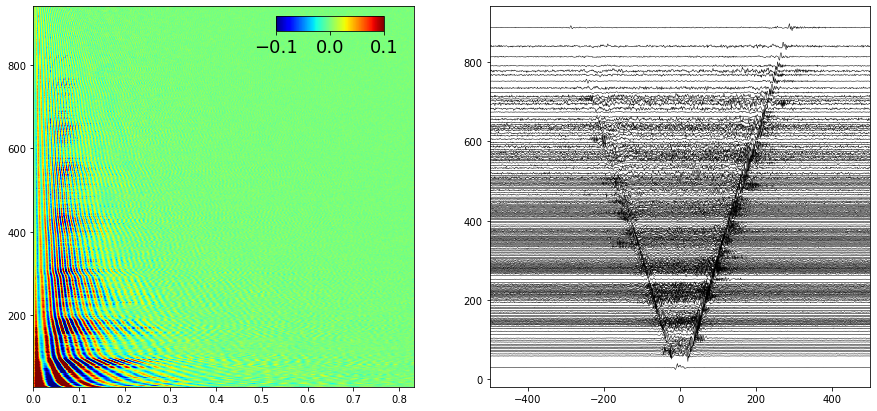

In [7]:
## plot
import matplotlib.pyplot as plt
idx = []
# select records, the 0.5 is depended on the data, or you can just donot do it
for i in range(len(ncfs0)):
    if np.max(abs(ncfs0[i,:]))>0.5:
        idx.append(i)
    
ncfs0 = np.delete(ncfs0,idx,axis=0)
r0 = np.delete(r0,idx,axis=0)
dt = 1/np.max(f) 
t = (np.linspace(-len(f)/2,len(f)/2-1,len(f))-0.5)*dt

ncfst = np.zeros(np.shape(ncfs0))
for i in range(len(ncfs)):
    ncfst[i,:] = np.real(np.fft.fftshift(np.fft.ifft(ncfs0[i,:])))


fig,ax = plt.subplots(ncols=2,figsize=(15,7))


stride = 25
for i in range(0,len(r),stride):
    ax[1].plot(t,np.real(ncfst[i,:])/np.max(np.real(ncfst[i,:]))*10+r0[i],'k',linewidth=0.5)
ax[1].set_xlim([-500,500])

               
ax[0] = plt.subplot(121)
im = plt.imshow(np.flip(np.real(ncfs0),0), extent=[min(f),max(f), min(r0), max(r0)], aspect='auto',cmap='jet',vmin=-0.1,vmax=0.1)

position=fig.add_axes([0.35, 0.83, 0.1, 0.03])
cb=plt.colorbar(im,cax=position,orientation='horizontal')
cb.ax.tick_params(labelsize=18) 
[label.set_fontname('Times New Roman') for label in cb.ax.get_xticklabels()]
 